<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# AI in Finance

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## Reinforcement Learning

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import gym

In [3]:
env = gym.make('CartPole-v0')

In [4]:
env.seed(100)
env.action_space.seed(100)

[100]

In [5]:
env.observation_space

Box(4,)

In [6]:
env.observation_space.low.astype(np.float16)

array([-4.8  ,   -inf, -0.419,   -inf], dtype=float16)

In [7]:
env.observation_space.high.astype(np.float16)

array([4.8  ,   inf, 0.419,   inf], dtype=float16)

In [8]:
state = env.reset()

In [9]:
state

array([-0.0163,  0.0238, -0.0392, -0.0148])

In [10]:
env.action_space

Discrete(2)

In [11]:
env.action_space.n

2

In [12]:
env.action_space.sample()

1

In [13]:
env.action_space.sample() 

0

In [14]:
a = env.action_space.sample()
a

1

In [15]:
state, reward, done, info = env.step(a)
state, reward, done, info

(array([-0.0158,  0.2195, -0.0395, -0.3196]), 1.0, False, {})

In [16]:
env.reset()
for e in range(1, 200):
    a = env.action_space.sample()
    state, reward, done, info = env.step(a) # <2>
    print(f'step={e:2d} | state={state} | action={a} | reward={reward}')
    if done and (e + 1) < 200:
        print('*** FAILED ***')
        break

step= 1 | state=[-0.0423  0.1982  0.0256 -0.2476] | action=1 | reward=1.0
step= 2 | state=[-0.0383  0.0028  0.0206  0.0531] | action=0 | reward=1.0
step= 3 | state=[-0.0383  0.1976  0.0217 -0.2331] | action=1 | reward=1.0
step= 4 | state=[-0.0343  0.0022  0.017   0.0664] | action=0 | reward=1.0
step= 5 | state=[-0.0343  0.197   0.0184 -0.2209] | action=1 | reward=1.0
step= 6 | state=[-0.0304  0.0016  0.0139  0.0775] | action=0 | reward=1.0
step= 7 | state=[-0.0303  0.1966  0.0155 -0.2107] | action=1 | reward=1.0
step= 8 | state=[-0.0264  0.0012  0.0113  0.0868] | action=0 | reward=1.0
step= 9 | state=[-0.0264  0.1962  0.013  -0.2023] | action=1 | reward=1.0
step=10 | state=[-0.0224  0.3911  0.009  -0.4908] | action=1 | reward=1.0
step=11 | state=[-0.0146  0.5861 -0.0009 -0.7807] | action=1 | reward=1.0
step=12 | state=[-0.0029  0.7812 -0.0165 -1.0736] | action=1 | reward=1.0
step=13 | state=[ 0.0127  0.9766 -0.0379 -1.3714] | action=1 | reward=1.0
step=14 | state=[ 0.0323  1.1722 -0.06

In [17]:
done

True

## Dimensionality Reduction

See http://kvfrans.com/simple-algoritms-for-solving-cartpole/.

In [18]:
np.random.seed(100)

In [19]:
weights = np.random.random(4) * 2 - 1

In [20]:
weights

array([ 0.0868, -0.4433, -0.151 ,  0.6896])

In [21]:
state = env.reset()

In [22]:
state

array([-0.0347, -0.0103,  0.047 , -0.0315])

In [23]:
s = np.dot(state, weights)
s

-0.02725361929630797

## Action Rule

In [24]:
if s < 0:
    a = 0
else:
    a = 1

In [25]:
a

0

## Total Reward per Episode

In [26]:
def run_episode(env, weights):  
    state = env.reset()
    treward = 0
    for _ in range(200):
        s = np.dot(state, weights)
        a = 0 if s < 0 else 1
        state, reward, done, info = env.step(a)
        treward += reward
        if done:
            break
    return treward

In [27]:
run_episode(env, weights)

41.0

## Simple Learning 

In [28]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)

In [29]:
set_seeds()
num_episodes = 1000

In [30]:
besttreward = 0
for e in range(1, num_episodes + 1):
    weights = np.random.rand(4) * 2 - 1
    treward = run_episode(env, weights)
    if treward > besttreward:
        besttreward = treward
        bestweights = weights
        if treward == 200:
            print(f'SUCCESS | episode={e}')
            break
        print(f'UPDATE  | episode={e}')

UPDATE  | episode=1
UPDATE  | episode=2
SUCCESS | episode=13


In [31]:
weights

array([-0.4282,  0.7048,  0.95  ,  0.7697])

## Testing the Results

In [32]:
res = []
for _ in range(100):
    treward = run_episode(env, weights)
    res.append(treward)
res[:10]

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]

In [33]:
sum(res) / len(res)

200.0

## DNN Learning

In [34]:
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [35]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(100)

In [36]:
class NNAgent:
    def __init__(self):
        self.max = 0
        self.scores = list()
        self.memory = list()
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=4,
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.001))
        return model
        
    def act(self, state):
        if random.random() <= 0.5:
            return env.action_space.sample()
        action = np.where(self.model.predict(
            state, batch_size=None)[0, 0] > 0.5, 1, 0)
        return action
                    
    def train_model(self, state, action):
        self.model.fit(state, np.array([action,]),
                       epochs=1, verbose=False)
    
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = env.reset()
            for _ in range(201):
                state = np.reshape(state, [1, 4])
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                if done:
                    score = _ + 1
                    self.scores.append(score)
                    self.max = max(score, self.max)
                    print('episode: {:4d}/{} | score: {:3d} | max: {:3d}'
                          .format(e, episodes, score, self.max), end='\r')
                    break
                self.memory.append((state, action))
                self.train_model(state, action)
                state = next_state

In [37]:
set_seeds(100)
agent = NNAgent()

In [38]:
episodes = 500

In [39]:
agent.learn(episodes)

In [40]:
sum(agent.scores) / len(agent.scores)

13.682

In [41]:
f = np.array([m[0][0] for m in agent.memory])
f

array([[-0.0163,  0.0238, -0.0392, -0.0148],
       [-0.0158,  0.2195, -0.0395, -0.3196],
       [-0.0114,  0.0249, -0.0459, -0.0396],
       ...,
       [ 0.0603,  0.9682, -0.0852, -1.4595],
       [ 0.0797,  1.1642, -0.1144, -1.7776],
       [ 0.103 ,  1.3604, -0.15  , -2.1035]])

In [42]:
l = np.array([m[1] for m in agent.memory])
l

array([1, 0, 1, ..., 1, 1, 1])

In [43]:
accuracy_score(np.where(agent.model.predict(f) > 0.5, 1, 0), l)

0.7525626872733008

## Q Learning

See https://keon.io/deep-q-learning/

In [44]:
from collections import deque
from keras.optimizers import Adam, RMSprop

In [45]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=Adam,
           lr=0.001, finish=False):
        self.finish = finish
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model(hu, opt, lr)
        
    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=opt(lr=lr))
        return model
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model.predict(state)[0]
        return np.argmax(action)
    
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:6.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')
                    break
            if av > 195 and self.finish:
                break
            if len(self.memory) > self.batch_size:
                self.replay()
    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])
                next_state, reward, done, info = env.step(action)
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

In [46]:
episodes = 1000

In [47]:
set_seeds(100)
agent = DQLAgent(finish=True)

In [48]:
agent.learn(episodes)

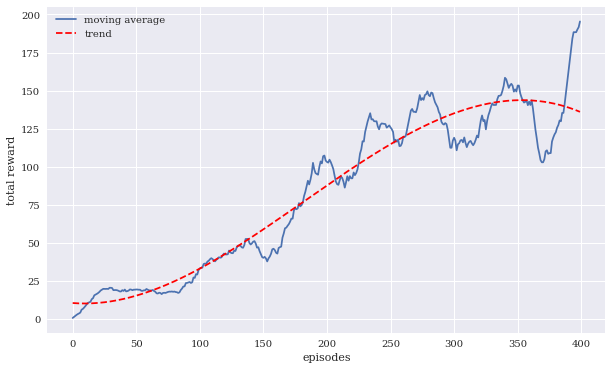

In [49]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='trend')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();
# plt.savefig('../../images/ch09/figure_rl_01.png');

In [50]:
trewards = agent.test(100)

In [51]:
sum(trewards) / len(trewards)

200.0

## Finance

In [52]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [53]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)

In [54]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    def __init__(self, symbol, features):
        self.symbol = symbol
        self.features = features
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        self.min_accuracy = 0.475
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
    def _get_state(self):
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values
    def seed(self, seed=None):
        pass
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self.data[self.features].iloc[
            self.bar - self.osn:self.bar]
        return state.values
    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.osn)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.osn + 10):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state, reward, done, info

In [55]:
env = Finance('EUR=', 'EUR=')

In [56]:
env.reset()

array([1.819 , 1.8579, 1.7749, 1.8579])

In [57]:
a = env.action_space.sample()
a

0

In [58]:
env.step(a)

(array([1.8579, 1.7749, 1.8579, 1.947 ]), 0, False, {})

In [59]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, opt=RMSprop)

In [60]:
episodes = 1000

In [61]:
agent.learn(episodes)

In [62]:
agent.test(3)

[2511, 2511, 2511]

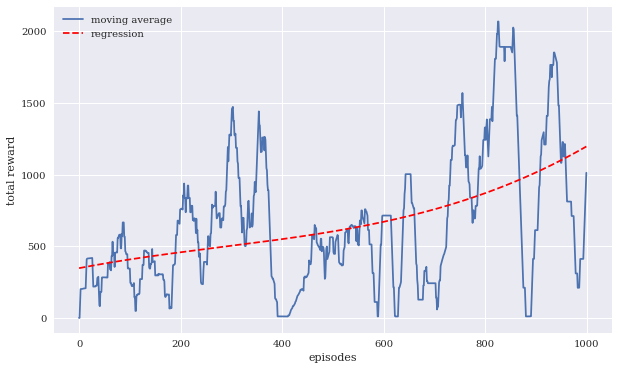

In [63]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();
# plt.savefig('../../images/ch09/figure_rl_02.png');

In [64]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    def __init__(self, symbol, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None):
        self.symbol = symbol
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data = self.data.iloc[self.start:]
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data['s'] = self.data[self.symbol].rolling(
                                              self.window).mean() 
        self.data['m'] = self.data['r'].rolling(self.window).mean()
        self.data['v'] = self.data['r'].rolling(self.window).std()
        self.data.dropna(inplace=True)
        if self.mu is None:
            self.mu = self.data.mean()
            self.std = self.data.std()
        self.data_ = (self.data - self.mu) / self.std
        self.data_['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data_['d'] = self.data_['d'].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]
    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                self.lags:self.bar]
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar-
                        self.lags:self.bar]
        return state.values
    def step(self, action):
        correct = action == self.data_['d'].iloc[self.bar]
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_1 = 1 if correct else 0
        reward_2 = abs(ret) if correct else -abs(ret)
        factor = 1 if correct else -1
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)
        if self.bar >= len(self.data):
            done = True
        elif reward_1 == 1:
            done = False
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 5):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state.values, reward_1 + reward_2 * 5, done, info

In [65]:
env = Finance('EUR=', ['EUR=', 'r'], 10, 5)

In [66]:
a = env.action_space.sample()
a

0

In [67]:
env.reset()

array([[ 1.7721, -1.0214],
       [ 1.5973, -2.4432],
       [ 1.5876, -0.1208],
       [ 1.6292,  0.6083],
       [ 1.6408,  0.1807]])

In [68]:
env.step(a)

(array([[ 1.5973, -2.4432],
        [ 1.5876, -0.1208],
        [ 1.6292,  0.6083],
        [ 1.6408,  0.1807],
        [ 1.5725, -0.9502]]),
 1.0272827803740798,
 False,
 {})

In [69]:
class FQLAgent:
    def __init__(self, hidden_units, learning_rate, learn_env, valid_env):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        self.learning_rate = learning_rate
        self.gamma = 0.95
        self.batch_size = 128
        self.max_treward = 0
        self.trewards = list()
        self.averages = list()
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.model = self._build_model(hidden_units, learning_rate)
        
    def _build_model(self, hu, lr):
        model = Sequential()
        model.add(Dense(hu, input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
                        activation='relu'))
        model.add(Dropout(0.3, seed=100))
        model.add(Dense(hu, activation='relu'))
        model.add(Dropout(0.3, seed=100))
        model.add(Dense(2, activation='linear'))
        model.compile(
            loss='mse',
            optimizer=RMSprop(lr=lr)
        )
        return model
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state)[0, 0]
        return np.argmax(action)
    
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0, 0])
            target = self.model.predict(state)
            target[0, 0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = \
                                self.learn_env.step(action)
                next_state = np.reshape(next_state,
                                [1, self.learn_env.lags,
                                 self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                  av, self.max_treward), end='\r')
                    break
            self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                self.replay()
    def validate(self, e, episodes):
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
        for _ in range(10000):
            action = np.argmax(self.model.predict(state)[0, 0])
            next_state, reward, done, info = self.valid_env.step(action)
            state = np.reshape(next_state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % 20 == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4d} | perf: {:5.3f} | '
                    templ += 'eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, treward,
                                       perf, self.epsilon))
                break

In [70]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [71]:
a = 0
b = 2000
c = 500

In [72]:
learn_env = Finance(symbol, features, window=10, lags=6,
                 leverage=1, min_performance=0.85,
                 start=a, end=a + b, mu=None, std=None)

In [73]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2010-01-19 to 2017-12-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2000 non-null   float64
 1   r       2000 non-null   float64
 2   s       2000 non-null   float64
 3   m       2000 non-null   float64
 4   v       2000 non-null   float64
dtypes: float64(5)
memory usage: 93.8 KB


In [74]:
valid_env = Finance(symbol, features, window=learn_env.window,
                 lags=learn_env.lags, leverage=learn_env.leverage,
                 min_performance=learn_env.min_performance,
                 start=a + b, end=a + b + c,
                 mu=learn_env.mu, std=learn_env.std)

In [75]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2017-12-27 to 2019-12-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    500 non-null    float64
 1   r       500 non-null    float64
 2   s       500 non-null    float64
 3   m       500 non-null    float64
 4   v       500 non-null    float64
dtypes: float64(5)
memory usage: 23.4 KB


In [76]:
set_seeds(100)
agent = FQLAgent(24, 0.0001, learn_env, valid_env)

In [77]:
episodes = 61

In [78]:
agent.learn(episodes)

episode: 20/61 | VALIDATION | treward:  494 | perf: 1.169 | eps: 0.68
episode: 40/61 | VALIDATION | treward:  494 | perf: 1.111 | eps: 0.45
episode: 60/61 | VALIDATION | treward:  494 | perf: 1.089 | eps: 0.30


In [79]:
agent.epsilon

0.291602079838278

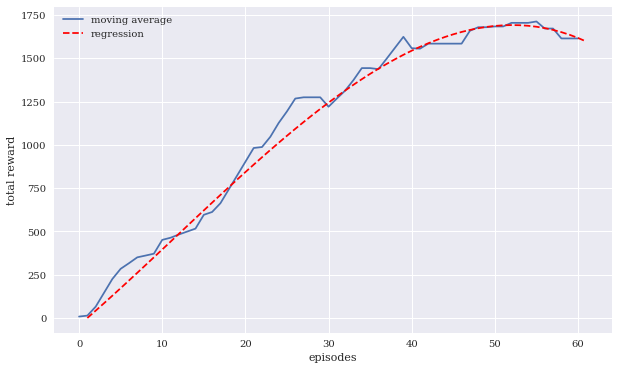

In [80]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();
# plt.savefig('../../images/ch09/figure_rl_03.png');

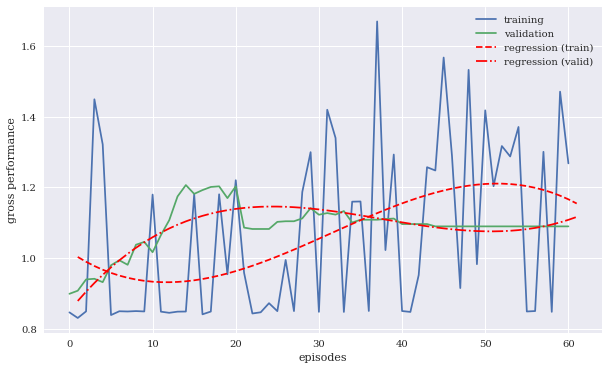

In [81]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.performances) + 1)
y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
plt.plot(agent.performances[:], label='training')
plt.plot(agent.vperformances[:], label='validation')
plt.plot(x, y, 'r--', label='regression (train)')
plt.plot(x, y_, 'r-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend();
# plt.savefig('../../images/ch09/figure_rl_04.png');

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">